# Project to Convert PNG containing a funtion plot to a CSV file

This specifically is being worked to read two utility transformer charts froma PDF 

https://www.elstersolutions.com/assets/downloads/Toronto_Hydro_Transformer_Monitors.pdf

The motive is to gather realistic looking tranformer data in order to synthesize more of it
for proving that a DL algo can detect anamolies in such signals


# Some Utility Functions for Images

In [1]:
# The code was removed by DSX for sharing.

,D,UD,X,X.1,class,classInt,meanY,meanYmean,meanYstd,newY,order,stdY
0,1,0,0,45,B,0,91.5,154.707804,35.721516,91.979918,1,0.707107
1,1,0,1,46,B,0,87.5,154.707804,35.721516,87.912618,2,1.290994
2,1,0,2,47,B,0,88.6,154.707804,35.721516,86.553241,3,3.204164
3,1,0,3,48,B,0,102.5,154.707804,35.721516,103.214549,4,0.707107
4,1,0,4,49,B,0,111.0,154.707804,35.721516,111.290193,5,1.581139


In [2]:
#simulatedNoLows.drop( ['Unnamed: 0'])


In [3]:
from PIL import Image
from __future__ import with_statement

def ConvertPNGtoDf(inputFile):
    import pandas as pd

    im = Image.open(inputFile) #relative path to file
    (w,h) = im.size
    #load the pixel info
    pix = im.load()

    #get a tuple of the x and y dimensions of the image
    width, height = im.size

    X = []
    Y = []
    r = []
    g = []
    b = []

    #read the details of each pixel and write them to the file
    for x in range(width):
        for y in range(height):
            X.append(x)
            Y.append(h - y)
            r.append(pix[x,y][0])
            g.append(pix[x,y][1])
            b.append(pix[x,y][2])

    rgb = [('X', X),
             ('Y', Y),
             ('R', r),
             ('G', g),
             ('B', b),
             ]
    df = pd.DataFrame.from_items( rgb )
    return df  

def DfColorFilter(df, Rlo, Rhi, Glo, Ghi, Blo, Bhi):
    #blue = df[(df.B>70)&(df.R<80)&(df.G<60)]
    rgb = df[(df.B>Blo) & (df.B<Bhi) & (df.R>Rlo) & (df.R<Rhi) & (df.G>Glo) & (df.G<Ghi)]
    return rgb  

def DfWriteCSV(df, outputFile):
    im = Image.open(inputFile) #relative path to file
    (w,h) = im.size
    #load the pixel info
    pix = im.load()

    #get a tuple of the x and y dimensions of the image
    width, height = im.size

    #open a file to write the pixel data
    with open(outputFile, 'w+') as f:
      f.write('X,Y,R,G,B\n')

      #read the details of each pixel and write them to the file
      for x in range(width):
        for y in range(height):
          r =  pix[x,y][0]
          g =  pix[x,y][1]
          b =  pix[x,y][2]
          f.write('{0},{1},{2},{3},{4}\n'.format(x,h-y,r,g,b))
    return  


def DfAddStats(rgb):
    meanY = rgb.groupby('X')['Y'].mean()
    stdY = rgb.groupby('X')['Y'].std()
    rgbT = pd.concat([meanY, stdY], axis=1)
    rgbT['meanYmean'] = meanY.mean()
    rgbT['meanYstd'] = meanY.std()
    rgbT.fillna(method='pad', inplace=True)
    rgbT['X'] = rgbT.index
    rgbT.columns = ['meanY', 'stdY', 'meanYmean', 'meanYstd', 'X']
    #rgbT.to_csv(outputFile, columns = rgbT.columns)
    return rgbT

def PlotTrimmed(rgb, X, Y, color, size):
    from PIL import Image
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt

    x = rgb[X].tolist()
    y = rgb[Y].tolist()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xtx = range(45,500,45)
    # set your ticks manually
    ax.xaxis.set_ticks(xtx)
    ax.grid(True)

    plt.scatter(x, y, c=color, s = size)
    #plt.scatter(redT.index, redT.meanY, c='k', s = 1)
    plt.show()
    return
        
from pandas.compat import lmap
import numpy as np

def SO_autocorrelation_plot(series, n_samples=None, ax=None, **kwds):
    """Autocorrelation plot for time series.
    see https://stackoverflow.com/questions/38503381/set-number-of-lags-in-python-pandas-autocorrelation-plot
    Parameters:
    -----------
    series: Time series
    ax: Matplotlib axis object, optional
    kwds : keywords
        Options to pass to matplotlib plotting method

    Returns:
    -----------
    ax: Matplotlib axis object
    """
    import matplotlib.pyplot as plt
    n = len(series)
    data = np.asarray(series)
    if ax is None:
        ax = plt.gca(xlim=(1, n_samples), ylim=(-1.0, 1.0))
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) *
                (data[h:] - mean)).sum() / float(n) / c0
    x = (np.arange(n) + 1).astype(int)
    y = lmap(r, x)
    z95 = 1.959963984540054
    z99 = 2.5758293035489004
    ax.axhline(y=z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.axhline(y=z95 / np.sqrt(n), color='grey')
    ax.axhline(y=0.0, color='black')
    ax.axhline(y=-z95 / np.sqrt(n), color='grey')
    ax.axhline(y=-z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    if n_samples:
        ax.plot(x[:n_samples], y[:n_samples], **kwds)
    else:
        ax.plot(x, y, **kwds)
    if 'label' in kwds:
        ax.legend()
    ax.grid()
    return ax

def ReadPNG(inputFile, outputFile, Rlo, Rhi, Glo, Ghi, Blo, Bhi):
    # read the png file, write it to csv raw, and return filtered dataframe with specified color channels specified
    im = Image.open(inputFile) #relative path to file
    (w,h) = im.size
    #load the pixel info
    pix = im.load()

    #get a tuple of the x and y dimensions of the image
    width, height = im.size

    #open a file to write the pixel data
    with open(outputFile, 'w+') as f:
      f.write('X,Y,R,G,B\n')

      #read the details of each pixel and write them to the file
      for x in range(width):
        for y in range(height):
          r =  pix[x,y][0]
          g =  pix[x,y][1]
          b =  pix[x,y][2]
          f.write('{0},{1},{2},{3},{4}\n'.format(x,h-y,r,g,b))

    df = pd.read_csv(outputFile)
    #blue = df[(df.B>70)&(df.R<80)&(df.G<60)]
    rgb = df[(df.B>Blo) & (df.B<Bhi) & (df.R>Rlo) & (df.R<Rhi) & (df.G>Glo) & (df.G<Ghi)]
    return rgb  

def writeRGBcsv(blue,outputFile):
    meanY = blue.groupby('X')['Y'].mean()
    stdY = blue.groupby('X')['Y'].std()
    blueT = pd.concat([meanY, stdY], axis=1)
    #blueT['meanY'] = meanY
    #blueT['stdY'] = stdY
    blueT['meanYmean'] = meanY.mean()
    blueT['meanYstd'] = meanY.std()
    #blueT.rename(columns = ['meanY', 'stdY', 'meanYmean', 'meanYstd'])
    blueT.columns = ['meanY', 'stdY', 'meanYmean', 'meanYstd']
    blueT.to_csv(outputFile, columns = blueT.columns)
    return blueT

def PlotTrimmed(rgb, color, size, colList):
    from PIL import Image
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt

    x = rgb[colList[0]].tolist()
    y = rgb[colList[1]].tolist()

    #plt.scatter(x, y, c=color, s = size)
    #plt.scatter(redT.index, redT.meanY, c='k', s = 1)
    #plt.show()
    
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=color, s=size, alpha=0.5)

    ax.grid(True)
    fig.tight_layout()

    plt.show()

    return


# Read the TorontoBlue.png file convert data to Pandas Dataframe

In [4]:
import pandas as pd
%matplotlib inline

,X,Y,R,G,B
9733,35,131,74,57,103
9734,35,130,68,53,120
9735,35,129,65,50,117
9736,35,128,64,57,110
10013,36,125,57,59,134


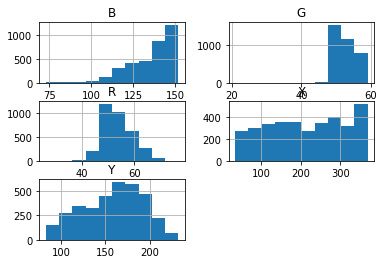

In [47]:
%matplotlib inline
import requests

#       blue = df[(df.B>70)&(df.R<80)&(df.G<60)]
#       blue = ReadPNG('TorontoBlue.png', 'blue_file_raw.csv', 0, 80, 0, 60, 70, 255)
blue = ConvertPNGtoDf('TorontoBlue.png')
blue = DfColorFilter(blue,  0, 80, 0, 60, 70, 250)
blue.to_csv('blue_raw.csv')

blue.hist()
blue.head()

## Display Blue Histogram

In [6]:
blueT = DfAddStats(blue)
blueT.head()


,meanY,stdY,meanYmean,meanYstd,X
X,,,,,
35,129.500000,1.290994,154.707804,35.721516,35
36,122.000000,2.160247,154.707804,35.721516,36
37,121.000000,2.160247,154.707804,35.721516,37
38,122.333333,3.162278,154.707804,35.721516,38
39,120.500000,1.290994,154.707804,35.721516,39


## Plot Blue trimmed data

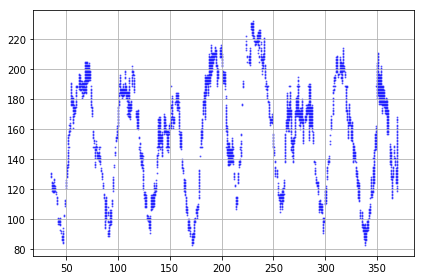

In [7]:
PlotTrimmed(blue, 'b', 1, ['X', 'Y'])

good page on aggregating user defined functions
https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/


# Read the TorontoRed.png file convert data to Pandas Dataframe

## Plot histogram of red data

In [8]:
inputFile = 'TorontoRed.png'
red = ConvertPNGtoDf(inputFile)
red = DfColorFilter(red, 190, 210, 0, 255, 0, 180)
#red.to_csv('red_raw.csv')


## Write csv for red data

In [9]:
redT = DfAddStats(red)
redT.head()

,meanY,stdY,meanYmean,meanYstd,X
X,,,,,
31,142.611111,5.542763,123.76477,46.365381,31
32,132.000000,5.542763,123.76477,46.365381,32
33,143.000000,5.542763,123.76477,46.365381,33
34,121.250000,13.889444,123.76477,46.365381,34
35,108.000000,13.889444,123.76477,46.365381,35


## Plot Red Transformer¶


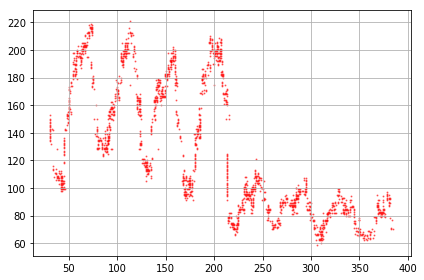

In [10]:
#PlotTrimmed(redT,  'X', 'meanY', 'r', 1)
PlotTrimmed(red, 'r', 1, ['X', 'Y'])


# Find the horizontal grid lines for TorontoBlue.png
to help establish vertical scale

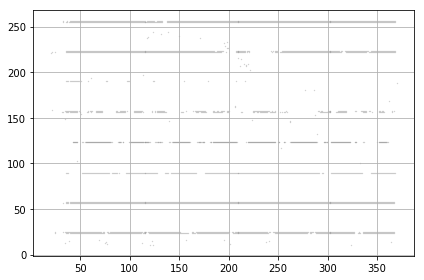

In [11]:
inputFile = 'TorontoBlue.png'
bluegray = ConvertPNGtoDf(inputFile)
bluegray = DfColorFilter(bluegray, 200, 224, 210, 220, 200, 220)

#bluegray = ReadPNG('TorontoBlue.png', 'bluegray_file_raw.csv', 200, 224, 210, 220, 200, 220)
bluegray.hist()
PlotTrimmed(bluegray, 'gray', .1, ['X', 'Y'])

# Histogram is easier to pick off the values

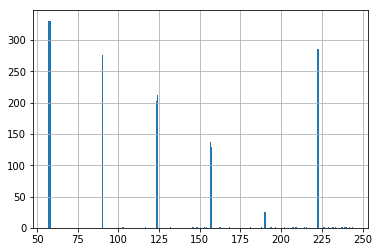

In [12]:
bluegray[(bluegray.X > 35) & (bluegray.Y > 35) & (bluegray.Y < 255)].Y.hist(bins=255)

In [13]:
bluegray[(bluegray.X > 35) & (bluegray.Y > 35) & (bluegray.Y < 255)].Y.head()

9915    223
9916    222
9948    190
9981    157
9982    156
Name: Y, dtype: int64

# Find the horizontal grid lines for TorontoRed.png

to establish vertical scale of data

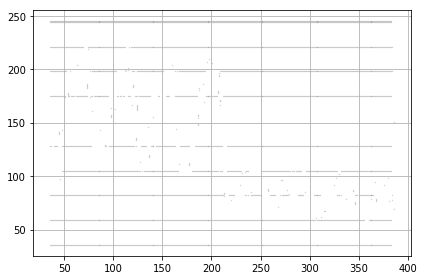

In [14]:
#redgray = ReadPNG('TorontoRed.png', 'redgray_file_raw.csv', 20, 224, 160, 224, 180, 240)
#redgray.hist()
#PlotTrimmed(redgray[(redgray.X > 35) & (redgray.Y > 35) & (redgray.Y < 255)],  'X', 'Y', 'gray', .1)


inputFile = 'TorontoRed.png'
redgray = ConvertPNGtoDf(inputFile)
redgray = DfColorFilter(redgray,  20, 224, 160, 224, 180, 240)

#bluegray = ReadPNG('TorontoBlue.png', 'bluegray_file_raw.csv', 200, 224, 210, 220, 200, 220)
redgray.hist()
PlotTrimmed(redgray[(redgray.X > 35) & (redgray.Y > 35) & (redgray.Y < 255)], 'gray', .1, ['X', 'Y'])

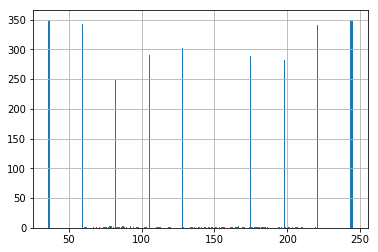

In [15]:
redgray[(redgray.X > 35) & (redgray.Y > 35) & (redgray.Y < 255)].Y.hist(bins=255)

In [16]:
#redT.plot.scatter('index', 'meanY', c='r')
red.head()

,X,Y,R,G,B
8455,31,153,200,177,173
8458,31,150,200,169,164
8459,31,149,198,164,158
8460,31,148,198,164,158
8461,31,147,201,163,158


# lag_plot

Look to see if random walk or if their is predictable pattern
https://pandas.pydata.org/pandas-docs/stable/visualization.html#lag-plot

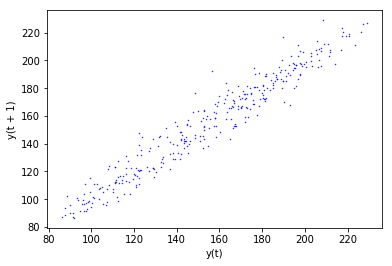

In [17]:
#from pandas.plotting import lag_plot
from pandas.tools.plotting import lag_plot
#data = pd.concat([blue.X, blue.Y.diff()], axis=1)
data = blueT
diff = data.meanY
#diff.iloc[3000] = 0
lag_plot(diff, c ='b', s=.2)

#autocorrelation_plot(diff)
#red[(red.X>190) & (red.X<235)  ].plot.scatter(x='X', y='Y', c='r', s=.2)


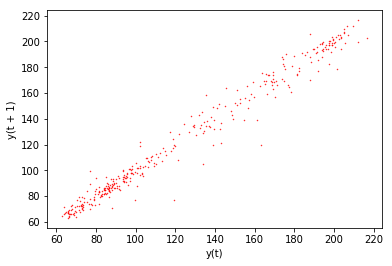

In [18]:
#from pandas.plotting import lag_plot
from pandas.tools.plotting import lag_plot
data = redT
lag_plot(data.meanY, c ='r', s=.2)

In [19]:
#blue[(blue.Y > 190) & (blue.Y.shift() > 140)]
#blue[(blue.X > 349) & (blue.X < 352)]
#blue[(blue.Y > 190) & (blue.Y.shift() > 140)]
#blue[(blue.X > 349) & (blue.X < 352)]

red[(red.Y > 140) & (red.Y.shift() < 90)]
red[(red.X > 214) & (red.X < 216)]
#red[(red.Y > 190) & (red.Y.shift() > 140)]
#red[(red.X > 349) & (red.X < 352)]

,X,Y,R,G,B
57951,215,153,200,124,115
57954,215,150,206,130,121
58022,215,82,201,95,91
58024,215,80,201,83,83
58025,215,79,200,66,74
58026,215,78,199,62,73
58028,215,76,193,73,74


# Autocorrelation plot on meanY: periodicity time

This plot is deisgned to capture the periodicity in the data - capture the roughly 41 to 44 time unit cycle

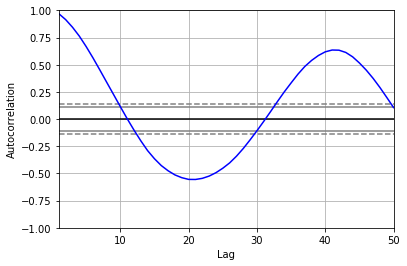

In [20]:
SO_autocorrelation_plot(blueT.meanY, n_samples=50, c='b')

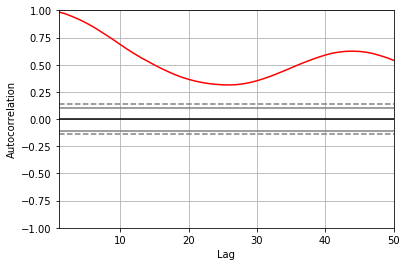

In [21]:
#from pandas.plotting import autocorrelation_plot
#autocorrelation_plot(redT.meanY)

SO_autocorrelation_plot(redT.meanY, n_samples=50, c='r')

meanY        0
stdY         0
meanYmean    0
meanYstd     0
X            0
dtype: int64

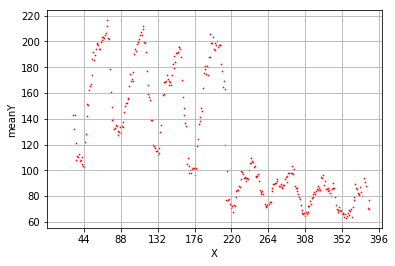

In [22]:
import matplotlib.pyplot as plt
xtx = range(44,500,44)
redT.plot.scatter('X', 'meanY', c='r', s=.5, grid=True, xlim=[0,400], xticks=xtx)

redT.isnull().sum()
#redT.isnull().any(1).nonzero()[0]
#redT.iloc[270:280]


In [23]:

#blueBreakout = pd.read_csv('blueT_breakout.csv')
#redBreakout = pd.read_csv('redT_breakout.csv')

blueBreakout['classInt'] = (blueBreakout['class'] == 'B') + 0
redBreakout['classInt'] = (redBreakout['class'] != 'B') + 0
allBreakout['classInt'] = (allBreakout['class'] != 'B') + 0
#blueT.groupby(['D']).X.rank()

In [24]:
allBreakout.head()

,X,meanY,stdY,meanYmean,meanYstd,X.1,D,order,class,classInt
0,31,142.611111,5.542763,123.76477,46.365381,31,0,1,R,1
1,32,132.000000,5.542763,123.76477,46.365381,32,0,2,R,1
2,33,143.000000,5.542763,123.76477,46.365381,33,0,3,R,1
3,34,121.250000,13.889444,123.76477,46.365381,34,0,4,R,1
4,35,108.000000,13.889444,123.76477,46.365381,35,0,5,R,1


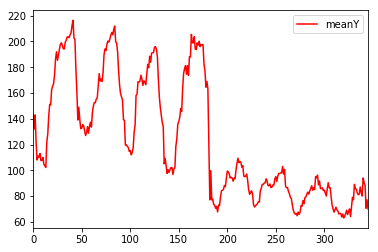

In [25]:
#%matplotlib notebook
redBreakout.plot(y='meanY', c='r')

# Experiment with converting data to image for CNN consumption

In [26]:
"""
from PIL import Image
import random

data = [random.choice((0, 1)) for _ in range(2500)]
data[:] = [data[i:i + 50] for i in range(0, 2500, 50)]
#print data

img = Image.new('1', (50, 50))
pixels = img.load()

for i in range(img.size[0]):
    for j in range(img.size[1]):
        pixels[i, j] = data[i][j]

img.show()
img.save('/tmp/image.png')
from IPython.display import display
from PIL import Image

from IPython.display import Image
path="/tmp/image.png"
i = Image(filename=path)
i
"""

'\nfrom PIL import Image\nimport random\n\ndata = [random.choice((0, 1)) for _ in range(2500)]\ndata[:] = [data[i:i + 50] for i in range(0, 2500, 50)]\n#print data\n\nimg = Image.new(\'1\', (50, 50))\npixels = img.load()\n\nfor i in range(img.size[0]):\n    for j in range(img.size[1]):\n        pixels[i, j] = data[i][j]\n\nimg.show()\nimg.save(\'/tmp/image.png\')\nfrom IPython.display import display\nfrom PIL import Image\n\nfrom IPython.display import Image\npath="/tmp/image.png"\ni = Image(filename=path)\ni\n'

# series esp for red is not stationary - time dependence spread seen in lag plot

Dont know how to correct for this as it seems to be an inherent part of the data

# try log to make more linear

Does not help at all

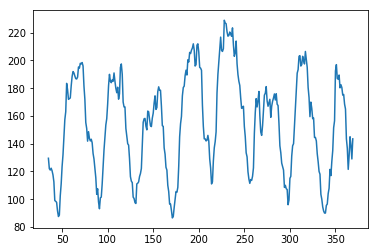

In [27]:
#ts_log = np.log(blueT.meanY)
plt.plot(blueT.X, blueT.meanY)

In [28]:
allT = pd.concat([redBreakout, blueBreakout])
allT.head()

,X,meanY,stdY,meanYmean,meanYstd,X.1,D,order,class,classInt
0,31,142.611111,5.542763,123.76477,46.365381,31,0,1,R,1
1,32,132.000000,5.542763,123.76477,46.365381,32,0,2,R,1
2,33,143.000000,5.542763,123.76477,46.365381,33,0,3,R,1
3,34,121.250000,13.889444,123.76477,46.365381,34,0,4,R,1
4,35,108.000000,13.889444,123.76477,46.365381,35,0,5,R,1


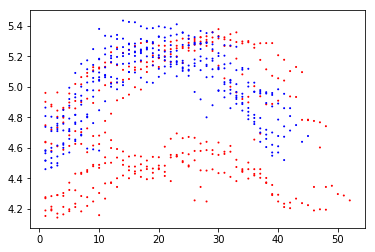

In [29]:
ts_log = np.log(allT.meanY)
plt.scatter(allT['order'], ts_log, c = allT['class'], s=1)

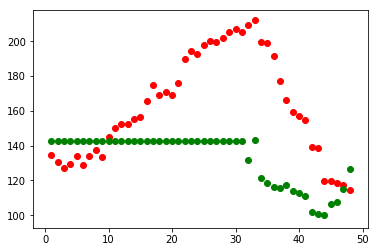

In [30]:
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=300)

D = 2
cls = 1

train = allBreakout[(allBreakout.D != D)|(allBreakout['classInt']  != cls)]
test  = allBreakout[ (allBreakout.D == D)&(allBreakout['classInt'] == cls)]

train_rows = train.index.tolist()
test_rows = test.index.tolist()

X = allBreakout.iloc[train_rows,0]
y = allBreakout.iloc[train_rows,1]

regr_1.fit(X.values.reshape(-1,1), y)

XTest = allBreakout.iloc[test_rows,0]
y_1 = regr_1.predict(test.order.values.reshape(-1,1))

if allBreakout['classInt'].iloc[0] == 1: 
    color = 'r'
else:
    color = 'b'
    
plt.scatter(test.order, test.meanY, c= color)
plt.scatter(test.order, y_1, c='g')

In [31]:
allBreakout.head()

,X,meanY,stdY,meanYmean,meanYstd,X.1,D,order,class,classInt
0,31,142.611111,5.542763,123.76477,46.365381,31,0,1,R,1
1,32,132.000000,5.542763,123.76477,46.365381,32,0,2,R,1
2,33,143.000000,5.542763,123.76477,46.365381,33,0,3,R,1
3,34,121.250000,13.889444,123.76477,46.365381,34,0,4,R,1
4,35,108.000000,13.889444,123.76477,46.365381,35,0,5,R,1


/usr/local/src/bluemix_jupyter_bundle.v94/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/bluemix_jupyter_bundle.v94/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


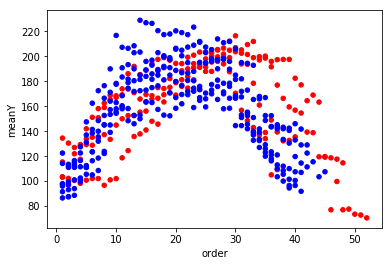

In [32]:
#Clip the ends and low voltage plots out
#sub = allT[~( allT['D'].isin([0,5,6,7,8]) ) | ~(allT['class'] == 'R' ) ]
#sub = allT[( allT['D'] ==  6 ) & (allT['class'] == 'B' ) ]
#sub = allT[~( allT['D'].isin([0,5,6,7,8]) ) | ~(allT['class'] == 'R' ) ]
noLow = allT[ (  ( allT['D'].isin([1,2,3,4]) ) & (allT['class'] == 'R' ) )  | (( allT['D'].isin([1,2,3,4,5,6,7]) ) & (allT['class'] == 'B' ))]
noLow.plot.scatter('order','meanY', c = noLow['class'])

#"""
noLow.groupby('order')['meanY'].mean()
meanYmean = noLow.groupby('order')['meanY'].median()
stdYmean = noLow.groupby('order')['meanY'].std()
#subT = pd.concat([meanYmean, stdYmean], axis=1)
for ord in range( int(noLow.order.max() ) ) :
    noLow.iloc[ord]['meanYmean'] = meanYmean.iloc[ord]
    noLow.iloc[ord]['meanYstd'] = stdYmean.iloc[ord]
#subT.fillna(method='pad', inplace=True)
#subT['X'] = rgbT.index
#subT.columns = ['meanY', 'stdY', 'meanYmean', 'meanYstd', 'X']
#"""

In [33]:
ord = 20
noLow.iloc[ord]['meanYmean'], meanYmean.iloc[ord]

(123.76477027700001, 186.9)

In [34]:
allBreakout.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 679 entries, 0 to 678
Data columns (total 10 columns):
X            679 non-null int64
meanY        679 non-null float64
stdY         679 non-null float64
meanYmean    679 non-null float64
meanYstd     679 non-null float64
X.1          679 non-null int64
D            679 non-null int64
order        679 non-null float64
class        679 non-null object
classInt     679 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 58.4+ KB


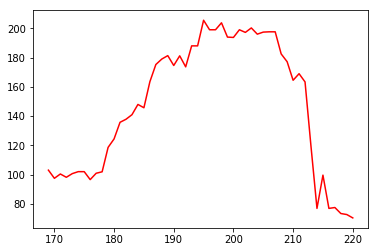

In [35]:
#ts_log = np.log(blueT.meanY)
cls = 1
D = 4
sub = allBreakout[(allBreakout['classInt'] == cls) & (allBreakout['D'] == D)]

if sub['classInt'].iloc[0] == 1: 
    color = 'r'
else:
    color = 'b'
plt.plot(sub.X, sub.meanY, c= color)

/usr/local/src/bluemix_jupyter_bundle.v94/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/src/bluemix_jupyter_bundle.v94/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


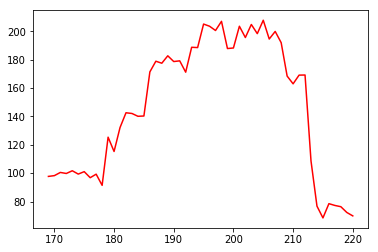

In [36]:
import random
# Use the height and width to calculate the area
def gensample(row):
    return abs(random.gauss(row['meanY'],row['stdY']))

#del subNew
subNew = sub.apply(gensample, axis = 1 )
sub.loc[:,'newY'] = subNew
#plt.plot(subNew.X, subNew.newY, c= color)
plt.plot(sub.X, sub.newY, c= color)

In [37]:
import random
random.gauss(10, 1)

8.894825928389174

In [38]:
import random
# Use the height and width to calculate the area
def gensample(row):
    return abs(random.gauss(row['meanY'],row['stdY']))

cls = 0
D = 1

#sub = allBreakout[(allBreakout['classInt'] == cls) & (allBreakout['D'] == D)]

simulated = pd.DataFrame(columns = sub.columns)
#subNew = sub.apply(gensample, axis = 1 )
#sub.loc[:,'newY'] = subNew
#simulated = pd.concat([simulated,sub])

for rep in range(10):
    for cls in range(0,2):
        for D in range(1,8): 
            if (cls == 1) & (D > 4):
                d = D - 4  # ensure that the low red red dont get inlcuded - choose the higher red days instead
            else:
                d = D
            sub = allBreakout[(allBreakout['classInt'] == cls) & (allBreakout['D'] == d)]
            subNew = sub.apply(gensample, axis = 1 )
            sub.loc[:,'newY'] = subNew
            #sub.loc[:,'X'] = sub.loc[:,'index'] 
            simulated = pd.concat([simulated,sub])
simulated.reset_index(drop = True, inplace = True)
simulated.X = simulated.index


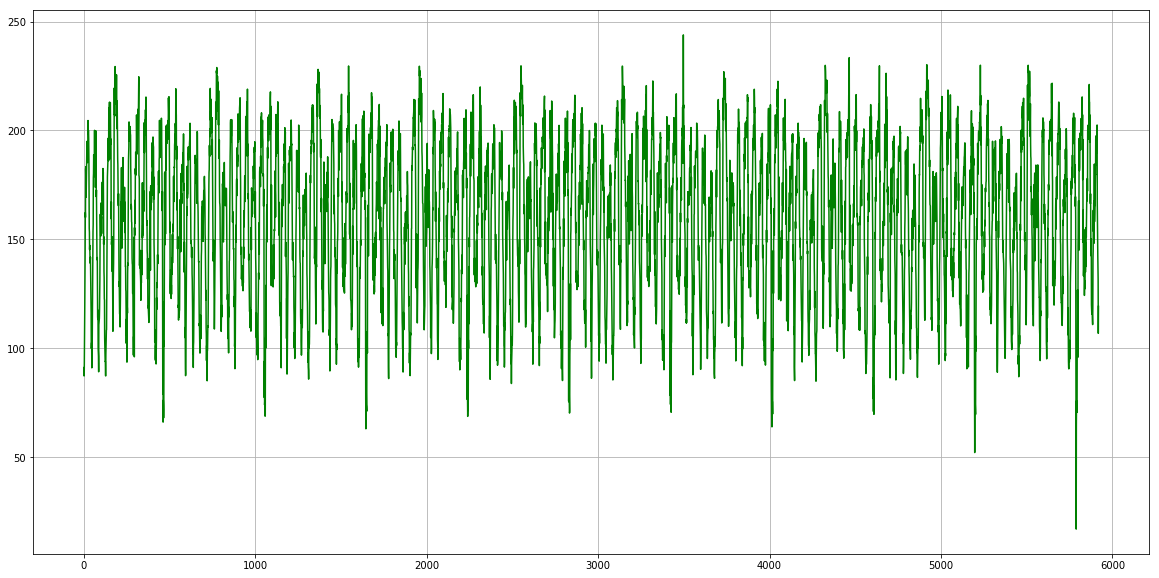

In [39]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
plt.plot(simulatedNoLows.X, simulatedNoLows.newY, c= 'g')



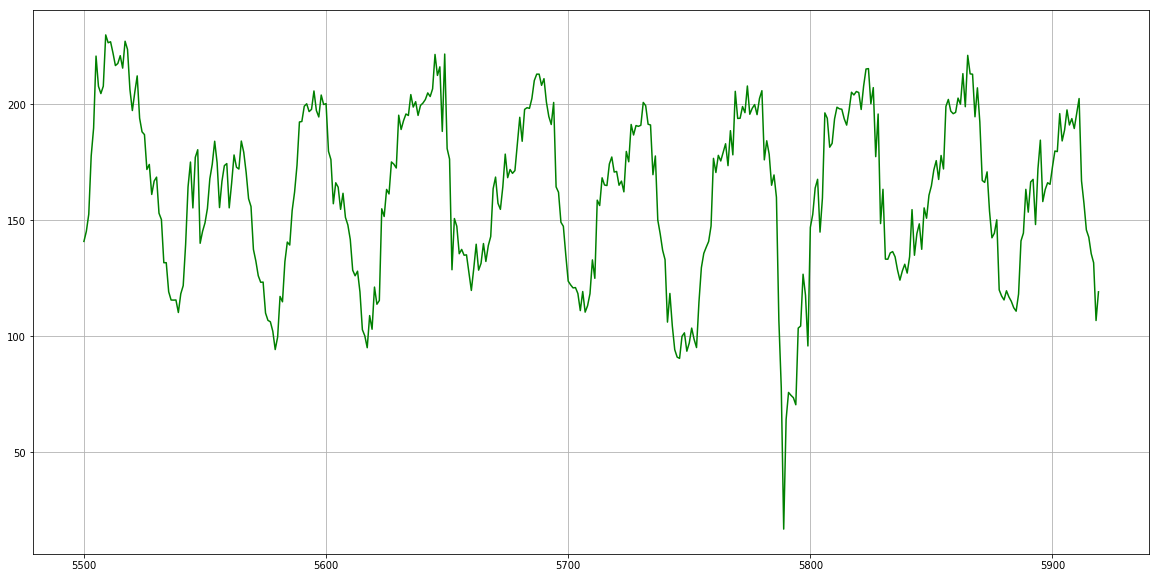

In [40]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
lo = 5500
hi = 6000
plt.plot(simulatedNoLows.X.iloc[lo:hi], simulatedNoLows.newY.iloc[lo:hi], c= 'g')

# Inject Mometary at known location for now

In [41]:

injectedMomentaryStart = 5635
injectedMomentaryDuration = 4
injectedMomentaryValue = .5 *  simulatedNoLows.iloc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration].newY.max()
InjectedMomentary = simulatedNoLows.copy()
InjectedMomentary.iloc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration]['newY'] = injectedMomentaryValue


/usr/local/src/bluemix_jupyter_bundle.v94/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
InjectedMomentary.iloc[injectedMomentaryStart:injectedMomentaryStart + injectedMomentaryDuration]

,X,meanY,stdY,meanYmean,meanYstd,X.1,D,order,class,classInt,newY,UD
5635,5635,199.0,5.656854,123.76477,46.365381,60,1,18,R,1,102.107543,133
5636,5636,197.0,1.414214,123.76477,46.365381,61,1,19,R,1,102.107543,133
5637,5637,194.4,3.361547,123.76477,46.365381,62,1,20,R,1,102.107543,133
5638,5638,194.2,4.779586,123.76477,46.365381,63,1,21,R,1,102.107543,133


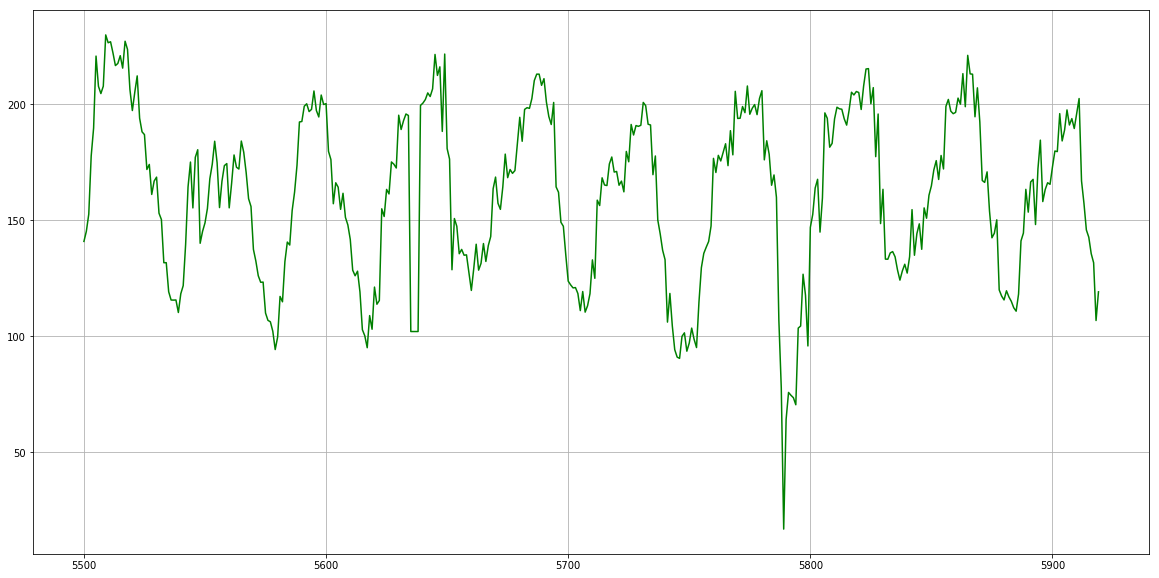

In [43]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
#xtx = range(45,500,45)
# set your ticks manually
#ax.xaxis.set_ticks(xtx)
ax.grid(True)
lo = 5500
hi = 6000
plt.plot(InjectedMomentary.X.iloc[lo:hi], InjectedMomentary.newY.iloc[lo:hi], c= 'g')

# Lag Plot Exploration of simulated and InjectedMomentary data

### First the SImulatedNoLows data (no momentary)

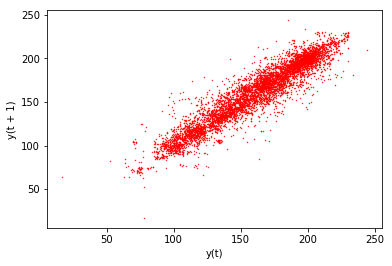

In [45]:
#from pandas.plotting import lag_plot
from pandas.tools.plotting import lag_plot
data = simulatedNoLows
lag_plot(data.newY, c ='r', s=.2)


### Now the InjectedMomentary

shows one case visually at about y(t)=100, y(t+1) = 200

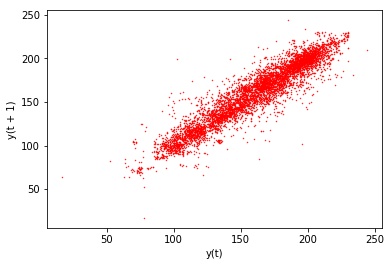

In [46]:
#from pandas.plotting import lag_plot
from pandas.tools.plotting import lag_plot
data = InjectedMomentary
lag_plot(data.newY, c ='r', s=.2)